# Part 3 ‐ Predictive modeling

## Problem Statement

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

Data description\
● city: city this user signed up in\
● phone: primary device for this user\
● signup_date: date of account registration; in the form ‘YYYYMMDD’\
● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’\
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup\
● avg_rating_by_driver: the rider’s average rating over all of their trips\
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips\
● surge_pct: the percent of trips taken with surge multiplier > 1\
● avg_surge: The average surge multiplier over all of this user’s trips\
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up\
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise\
● weekday_pct: the percent of the user’s trips occurring during a weekday

## Solution

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random_seed = 33
np.random.seed(random_seed)

In [3]:
# Load files

df = pd.read_json('ultimate_data_challenge.json')
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [4]:
# Show info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
# Convert date columns to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [6]:
# Check for nulls
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [7]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer


def iterative_imputer(p_data, p_col, p_strategy='mean', rs=33):
    """
    Impute missing values in a DataFrame using the specified strategy.
    
    Parameters:
    - p_data: DataFrame with missing values
    - p_col: Column name to impute
    - p_strategy: Imputation strategy ('mean', 'median', 'most_frequent')

    Returns:
    - numpy array with imputed values
    """
    imputer  = IterativeImputer(random_state=rs, initial_strategy=p_strategy)
    imputed = imputer.fit_transform(p_data[[p_col]])
    return imputed



In [8]:
# Impute missing rating values via IterativeImputer()
cols_num_impute = ['avg_rating_of_driver', 'avg_rating_by_driver']

for col in cols_num_impute:
    df[col] = iterative_imputer(df, col, p_strategy='mean')
    print(f"Imputed {col} using IterativeImputer with mean strategy.")


Imputed avg_rating_of_driver using IterativeImputer with mean strategy.
Imputed avg_rating_by_driver using IterativeImputer with mean strategy.


In [9]:
df.isna().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

In [10]:
# Describe the data
df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000,50000.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601559,1.074764,2014-04-19 08:02:04.992000256,8.849536,60.926084,5.796827,4.778158
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2014-01-09 00:00:00,4.500000,1.000000,2014-02-14 00:00:00,0.000000,33.300000,2.420000,4.700000
50%,1.000000,2014-01-17 00:00:00,4.700000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,100.000000,6.940000,5.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000
std,3.792684,NaN,0.564977,0.222336,NaN,19.958811,37.081503,5.707357,0.445753


### Fraction of Active users (retained over the last 30 days)

In [11]:
# Get the first and last trip dates
df['last_trip_date'].max()  # last trip date
df['last_trip_date'].min()  # first trip date

print(f'Latest trip date: {df["last_trip_date"].max()}')
print(f'First trip date: {df["last_trip_date"].min()}') 

Latest trip date: 2014-07-01 00:00:00
First trip date: 2014-01-01 00:00:00


Go back 30 days prior to the latest last trip date and set the date as a the cutoff date. 

In [12]:
# Define cutoff for retention: June 30, 2014 - 30 days = June 1, 2014
cutoff_date = df['last_trip_date'].max() - pd.Timedelta(days=30)
print(f'Cutoff date: {cutoff_date}')


Cutoff date: 2014-06-01 00:00:00


In [13]:
# Add new retention column
df['retained'] = df['last_trip_date'] >= cutoff_date

In [14]:
# Calculate fraction retained
fraction_retained = df['retained'].mean()
print(f'Fraction of users who retained: {round(fraction_retained,3)}')

Fraction of users who retained: 0.376


<div class="alert alert-block alert-info">
37.6 % of users were considered active or retained
</div>

### Building a predictive model

In [15]:
# Get fearures and target
y = df['retained']
X = df.drop(columns=['retained', 'last_trip_date', 'signup_date'])

In [16]:
# Convert categorical label to 0 and 1
y = y.astype(int)

In [17]:
# Get numeric columns
cols_numeric = X.select_dtypes(include=[np.number]).columns.tolist()
# Get categorical columns
cols_categorical = X.select_dtypes(include='object').columns.tolist()


print(f'Numeric columns: {cols_numeric}')
print(f'Categorical columns: {cols_categorical}')

Numeric columns: ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
Categorical columns: ['city', 'phone']


##### Class Imbalance

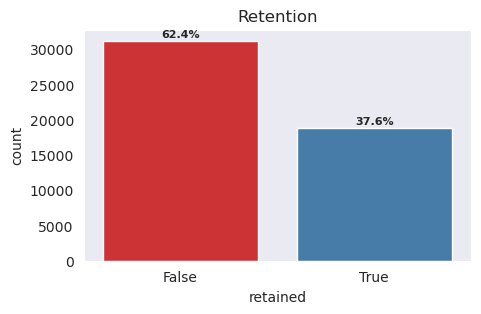

In [18]:
# Plot proprtion of retained users
sns.set_style('dark')
plt.figure(figsize=(5, 3))

ax = sns.countplot(x='retained', data=df, palette='Set1',hue='retained')

plt.title('Retention')
plt.legend().remove()

total = y.count()

for container in ax.containers:
    ax.bar_label(container, labels=[f'{(v/total)*100:0.1f}%' for v in container.datavalues], weight='bold', label_type='edge', fontsize=8, padding=1)

There's a class imbalance on the data with roughly 38% of the users Active. 


> - Since there's a class imbalance, ensure the splitting is stratified, and set the class_weight set to 'balanced'. 

In [19]:
X_numeric = pd.concat([X[cols_numeric], y], axis=1)
X_numeric

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,4,4.700000,1.10,15.4,46.2,3.67,5.0,1
1,0,5.000000,1.00,0.0,50.0,8.26,5.0,0
2,3,4.300000,1.00,0.0,100.0,0.77,5.0,0
3,9,4.600000,1.14,20.0,80.0,2.36,4.9,1
4,14,4.400000,1.19,11.8,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,100.0,5.63,4.2,1
49996,1,4.601559,1.00,0.0,0.0,0.00,4.0,0
49997,0,5.000000,1.00,0.0,100.0,3.86,5.0,0
49998,2,3.000000,1.00,0.0,100.0,4.58,3.5,0


##### Features correlation

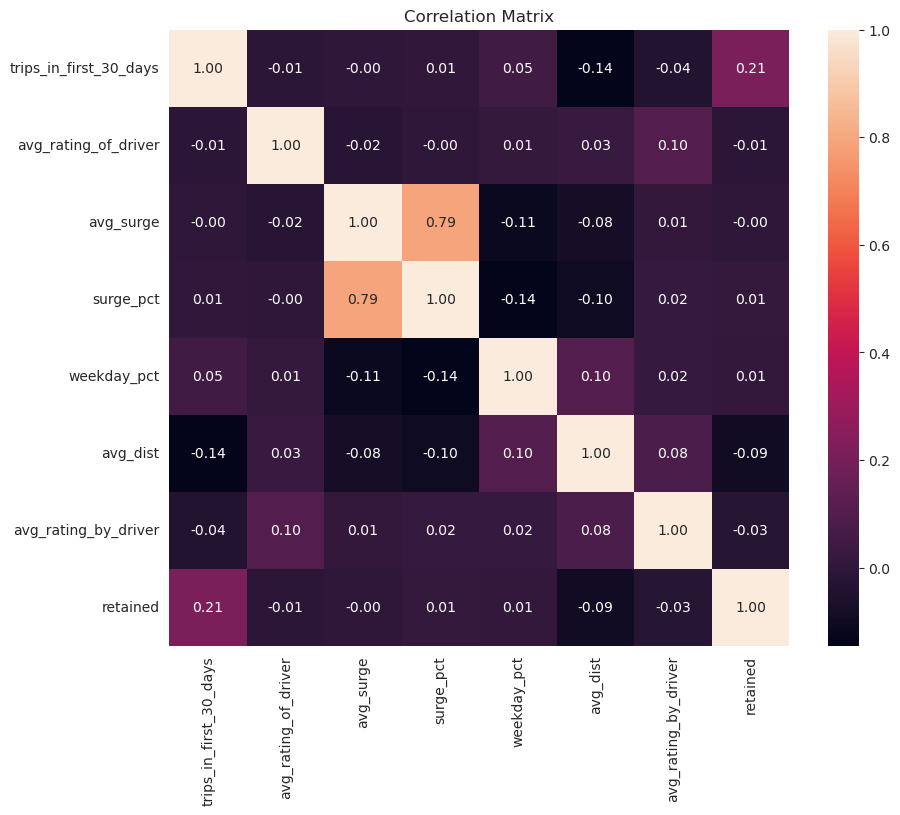

In [20]:
# See correlation matrix

X_corr = X_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(X_corr, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

##### Transformation/Encoding

In [21]:
# X.ultimate_black_user.astype(int)
# X['ultimate_black_user'] = X['ultimate_black_user'].astype(int)

In [22]:
# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder

In [23]:
def label_encoder(p_data, cat_col, enc_label):
    """
    Label encode a categorical column in a DataFrame.
    
    Parameters:
    - p_data: DataFrame with categorical column
    - cat_col: Column name to encode
    - enc_label: LabelEncoder object
    
    Returns:
    - DataFrame with encoded column
    """

    le = LabelEncoder()
    le.fit(p_data[cat_col])
    p_data[enc_label] = le.transform(p_data[cat_col])

    mapped_labels = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Label mapping for {cat_col}: {mapped_labels}")



    p_data[enc_label] = p_data[enc_label].apply(lambda x: np.NaN if x== mapped_labels.get(np.nan) else x)

    return mapped_labels

In [24]:
map_phone = label_encoder(X, 'phone', 'phone_enc')
map_city = label_encoder(X, 'city', 'city_enc')
map_retention = label_encoder(df, 'retained', 'retention_enc')

Label mapping for phone: {'Android': 0, 'iPhone': 1, None: 2}
Label mapping for city: {'Astapor': 0, "King's Landing": 1, 'Winterfell': 2}
Label mapping for retained: {False: 0, True: 1}


##### Impute missing values

In [25]:
def iterative_imputer_estimator(p_data, p_feats=[], p_estimator = None, p_strategy= 'mean', rs = 33):
    """
    Impute missing values in a DataFrame using the specified estimator.
    
    Parameters:
    - p_data: DataFrame with missing values
    - p_feats: List of features to impute
    - p_estimator: Estimator for imputation (e.g., RandomForestClassifier)
    - rs: Random state for reproducibility
    
    Returns:
    - numpy.ndarray with imputed values
    """
    
    imputer = IterativeImputer(estimator=p_estimator, strategy=p_strategy, random_state=rs)
    imputed = imputer.fit_transform(p_data[p_feats])
    
    return imputed

##### Chi-square test on categorical columns

In [26]:
# Drop categorical columns 
X = X.drop(columns=['phone', 'city'])
X_cats = X[['phone_enc', 'city_enc']]

In [27]:
# Perform Chi-Squared test on categorical features using encoded columns

from sklearn.feature_selection import chi2

chi_results = chi2(X_cats,y)
chi_results

(array([745.50223874, 152.76245895]),
 array([3.81400017e-164, 4.31705329e-035]))

> Testing the association of each categorical column and income at $\alpha$ = 0.05:
> - H0 : There is NO significant association between each of the categorical columns and income.
> - HA : There is a significant association between each of the categorical columns and income.
>    


In [28]:
alpha = 0.05
chi_scores = pd.Series(chi_results[0], index=X_cats.columns).sort_values(ascending=False)
p_values = pd.Series(chi_results[1], index=X_cats.columns).sort_values()


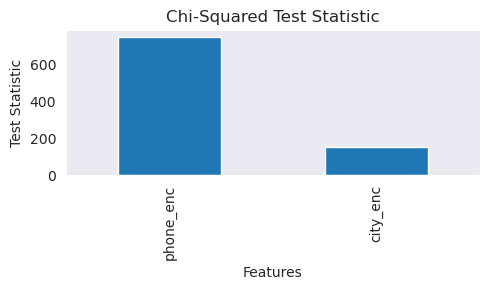

In [29]:
# Plot Chi-Squared T-Statistic test results
plt.figure(figsize=(5,3))
chi_scores.plot.bar()
plt.xlabel('Features')
plt.ylabel('Test Statistic')
plt.title('Chi-Squared Test Statistic')
plt.tight_layout()
plt.show()

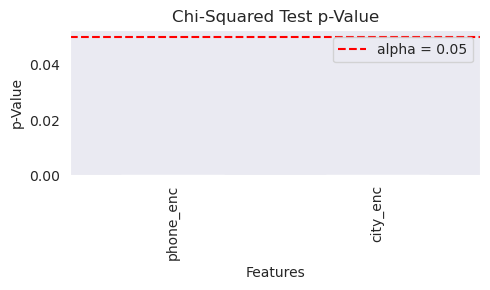

In [30]:
# Plot Chi-Squared test results p-values
plt.figure(figsize=(5,3))
p_values.plot.bar()
plt.xlabel('Features')
plt.ylabel('p-Value')
plt.title('Chi-Squared Test p-Value')
plt.axhline(y=alpha, linestyle='--', color='red', label=f'alpha = {alpha}')
plt.legend()
plt.tight_layout()
plt.show()

> As the p-values are significantly below 0.05, we reject the H0 that there is NO significant association between these features and the label. 

##### Dummy Features

In [31]:
X.drop(['phone_enc', 'city_enc'], axis=1, inplace=True)

In [32]:
df_obj = df.select_dtypes(include='object')

In [33]:
X = pd.concat([X, df_obj], axis=1)
X

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city,phone
0,4,4.700000,1.10,15.4,True,46.2,3.67,5.0,King's Landing,iPhone
1,0,5.000000,1.00,0.0,False,50.0,8.26,5.0,Astapor,Android
2,3,4.300000,1.00,0.0,False,100.0,0.77,5.0,Astapor,iPhone
3,9,4.600000,1.14,20.0,True,80.0,2.36,4.9,King's Landing,iPhone
4,14,4.400000,1.19,11.8,False,82.4,3.13,4.9,Winterfell,Android
...,...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,False,100.0,5.63,4.2,King's Landing,iPhone
49996,1,4.601559,1.00,0.0,False,0.0,0.00,4.0,Astapor,iPhone
49997,0,5.000000,1.00,0.0,True,100.0,3.86,5.0,Winterfell,Android
49998,2,3.000000,1.00,0.0,False,100.0,4.58,3.5,Astapor,iPhone


In [34]:
X = pd.get_dummies(X, drop_first=True)
X

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.700000,1.10,15.4,True,46.2,3.67,5.0,True,False,True
1,0,5.000000,1.00,0.0,False,50.0,8.26,5.0,False,False,False
2,3,4.300000,1.00,0.0,False,100.0,0.77,5.0,False,False,True
3,9,4.600000,1.14,20.0,True,80.0,2.36,4.9,True,False,True
4,14,4.400000,1.19,11.8,False,82.4,3.13,4.9,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,False,100.0,5.63,4.2,True,False,True
49996,1,4.601559,1.00,0.0,False,0.0,0.00,4.0,False,False,True
49997,0,5.000000,1.00,0.0,True,100.0,3.86,5.0,False,True,False
49998,2,3.000000,1.00,0.0,False,100.0,4.58,3.5,False,False,True


In [35]:
X.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'city_King's Landing', 'city_Winterfell',
       'phone_iPhone'],
      dtype='object')

##### Train-Test Split

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=33)
print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Train set size: 40000
Test set size: 10000


In [37]:
# value_counts in y_train and y_test

display(np.array(np.unique(y_train, return_counts=True)).T)
display(np.array(np.unique(y_test, return_counts=True)).T)

array([[    0, 24957],
       [    1, 15043]])

array([[   0, 6239],
       [   1, 3761]])

##### Scaling

In [38]:
# Scale the data before hyperparameter tuning
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Hyperparameter Tuning

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

In [40]:
space_rfc = {
    'n_estimators': hp.uniformint('n_estimators', 100, 200, q=100),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    # 'min_samples_split': hp.uniformint('min_samples_split', 1, 10, q=3),
    # 'min_samples_leaf': hp.uniformint('min_samples_leaf', 1, 6, q=1),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),

    # Tweak later
    # 'max_samples': hp.uniform('max_samples', 0.1, 1.0),
    # 'bootstrap': hp.choice('bootstrap', [True, False]),
    # 'class_weight': hp.choice('class_weight', [None, 'balanced']),
    # 'oob_score': hp.choice('oob_score', [True, False]),
    # 'warm_start': hp.choice('warm_start', [True, False]),
    # 'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.1),
    # 'max_features': hp.uniform('max_features', 0.1, 1.0),
    # 'max_leaf_nodes': hp.choice('max_leaf_nodes', [None, 10, 20, 30]),
    # 'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
    # 'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.5),
    # 'min_impurity_split': hp.uniform('min_impurity_split', 0.0, 0.5),
    # 'n_jobs': hp.choice('n_jobs', [None, -1]),
    # 'random_state': hp.choice('random_state', [None, 33]),
    # 'verbose': hp.choice('verbose', [0, 1]),
    # 'warm_start': hp.choice('warm_start', [True, False]),
    # 'class_weight': hp.choice('class_weight', [None, 'balanced']),
    # 'max_leaf_nodes': hp.choice('max_leaf_nodes', [None, 10, 20, 30]),
    # 'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.5),
    # 'min_impurity_split': hp.uniform('min_impurity_split', 0.0, 0.5),
    # 'max_depth': hp.choice('max_depth', [None, 10, 20, 30]),
}

In [41]:
def objective_rfc(space):
    """
    Objective function for hyperparameter optimization of RandomForestClassifier.
    
    Parameters:
    - space: Dictionary of hyperparameters
    
    Returns:
    - Dictionary with loss, status, and hyperparameters
    """
    
    # Create a pipeline with the specified hyperparameters
    clf = RandomForestClassifier(
        n_estimators=int(space['n_estimators']),
        max_features=space['max_features'],
        # min_samples_split=int(space['min_samples_split']),
        # min_samples_leaf=int(space['min_samples_leaf']),
        criterion=space['criterion'],
        random_state=random_seed,
        # n_jobs=-1
    )

    # Fit the model
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)
    

    loss = log_loss(y_test, y_pred)

    # Return the loss and status
    return {'loss': loss, 'status': STATUS_OK, 'model': clf}    

In [42]:
#Run trials and minimize the objective function
trials = Trials()

smbo_res = fmin(fn=objective_rfc,
                space=space_rfc,
                algo=tpe.suggest,
                max_evals=10,
                trials=trials,
                rstate=np.random.default_rng(random_seed)
)

100%|██████████| 10/10 [01:17<00:00,  7.78s/trial, best loss: 8.733377216183086]


In [43]:
# Determine the best loss and hyperparameters

losses = trials.losses()
best_loss = min(losses)

smbo_best = space_eval(space_rfc, smbo_res) #trials.argmin
print(f"Best loss: {best_loss}") 
print(f"Best hyperparameters: {smbo_best}")   

Best loss: 8.733377216183086
Best hyperparameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 165}


##### Rebuild the model

In [44]:
smbo_manual = {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 165}

In [45]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier()) ])

pipe.set_params(
    rfc__n_estimators=smbo_best['n_estimators'],
    rfc__max_features=smbo_best['max_features'],
    rfc__criterion=smbo_best['criterion'],
    # rfc__min_samples_split=smbo_best['min_samples_split'],
    # rfc__min_samples_leaf=smbo_best['min_samples_leaf'],
    # rfc__max_samples=smbo_best['max_samples'],
    # rfc__bootstrap=smbo_best['bootstrap'],
    # rfc__class_weight=smbo_best['class_weight'],
    # rfc__oob_score=smbo_best['oob_score'],
    # rfc__warm_start=smbo_best['warm_start'],
    # rfc__ccp_alpha=smbo_best['ccp_alpha'],
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.66060606, 0.65454545, 0.12727273, ..., 0.11515152, 0.35757576,
       0.01212121])

In [46]:
class_names = list(map_retention.keys())
class_names = class_names[::-1 ]
print(f"Class names: {class_names}")

Class names: [True, False]


#### Confusion Matrix  

In [48]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

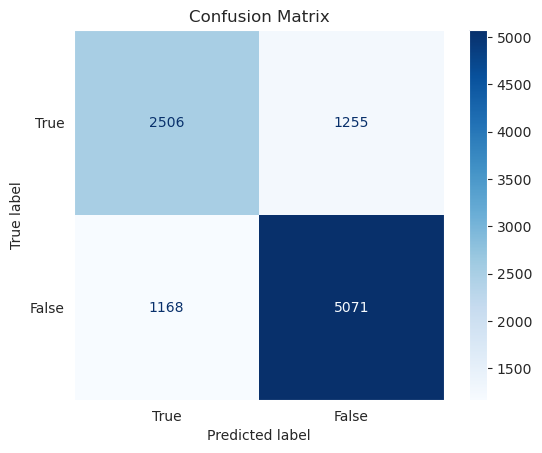

In [49]:
# DIsplay confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


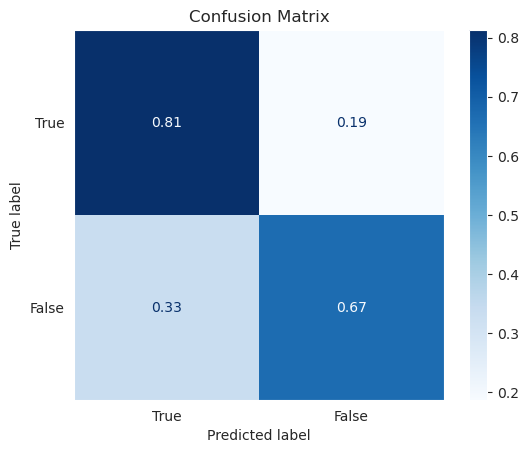

In [50]:
# Display Normalized confusion marix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                               display_labels=class_names, 
                                                normalize='true', 
                                                cmap=plt.cm.Blues, 
                                                values_format='.2f')
plt.title('Confusion Matrix')
plt.show()

In [51]:
# Get metrics

tn, fp, fn, tp = cnf_matrix.ravel()
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
loss = log_loss(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision_val = precision_score(y_test.values, y_pred, average='weighted')
recall_val = recall_score(y_test.values, y_pred, average='weighted')


In [52]:
# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Log Loss: {loss:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.7577
Precision: 0.7567
Recall: 0.7577
F1 Score: 0.7571
Log Loss: 8.7334
ROC AUC: 0.8230


##### Show Feature Importance

11


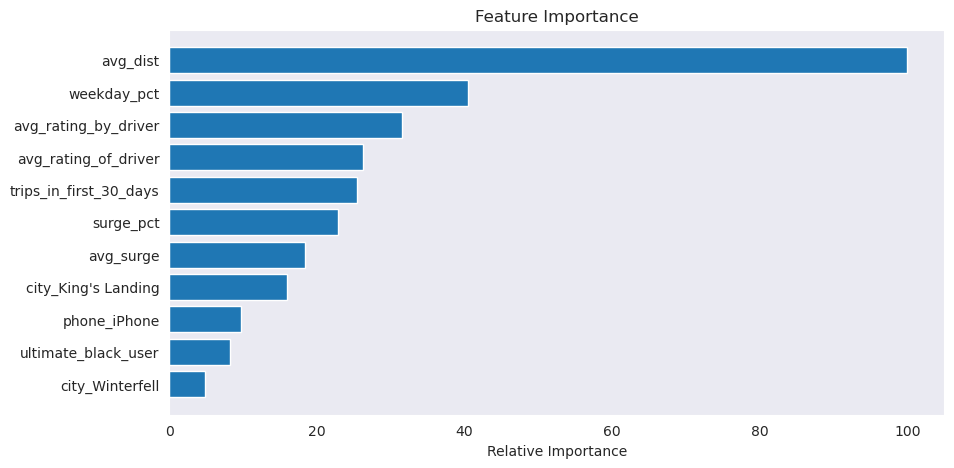

In [53]:
# Make importances relative to max importance

feature_importance = pipe.named_steps['rfc'].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()
